# Reading general data of the problems


In [1]:
# coding=utf-8
from __future__ import division
import json
import os
import sys

from MyUtils import clean_folder, read_files
from Word2Dim import Word2Dim

dataset_path = '.' + os.sep + 'pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23'
outpath = '.' + os.sep + 'dev_out'

clean_folder(outpath)

infocollection = dataset_path + os.sep + 'collection-info.json'
problems = []
language = []
with open(infocollection, 'r') as f:
    for attrib in json.load(f):
        problems.append(attrib['problem-name'])
        language.append(attrib['language'])
print('Reading general data of the problems, done!')


Reading general data of the problems, done!


# Reading problem 1

In [2]:



problem = problems[0]
index = 0
infoproblem = dataset_path + os.sep + problem + os.sep + 'problem-info.json'
candidates = []
with open(infoproblem, 'r') as f:
    fj = json.load(f)
    unk_folder = fj['unknown-folder']
    for attrib in fj['candidate-authors']:
        candidates.append(attrib['author-name'])

candidates.sort()
# Building training set
train_docs = []
for candidate in candidates:
    train_docs.extend(read_files(dataset_path + os.sep + problem, candidate))
train_texts = [text for i, (text, label) in enumerate(train_docs)]
train_labels = [label for i, (text, label) in enumerate(train_docs)]
index_2_label_dict = {i: l for i, l in enumerate(set(train_labels))}
label_2_index_dict = {l: i for i, l in enumerate(set(train_labels))}
train_labels = [label_2_index_dict[v] for v in train_labels]
w2d = Word2Dim()
train_tokenized_with_pos, train_tokenized_indexed = w2d.fit_transform_texts(train_texts, train_labels,
                                                                            language[index])

maxlen = len(max(train_tokenized_indexed, key=len))  # We will cut the texts after # words
embedding_dim = w2d.word_embedding.shape[1]

# preparing test set
ground_truth_file = dataset_path + os.sep + problem + os.sep + 'ground-truth.json'
gt = {}
with open(ground_truth_file, 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs = read_files(dataset_path + os.sep + problem, unk_folder, gt)
test_texts = [text for i, (text, label) in enumerate(test_docs)]
test_labels = [label for i, (text, label) in enumerate(test_docs)]

# Filter validation to known authors
test_texts = [text for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]
test_labels = [label for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]

test_labels = [label_2_index_dict[v] for v in test_labels]

test_tokenized_with_pos, test_tokenized_indexed = w2d.transform(test_texts)
print("Reading problem 1, done!")

doc count to process:  63
process_doc, done!
doc count to process:  468
Reading problem 1, done!


# Keras Stuff


In [ ]:
[index_2_label_dict[test_label] for test_label in test_labels]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 1020, 9)           68607     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1020, 32)          320       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1018, 32)          3104      
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 297       
Total params: 72,328
Trainable params: 72,328
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 468 samples
Epoch 1/50
63/63 [==============================] - 4s 56ms/step - loss: 0.0375 - acc: 0.8095

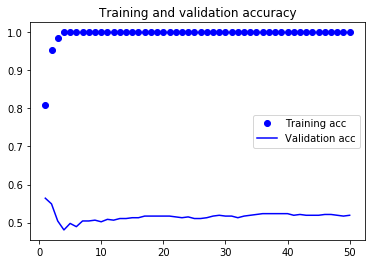

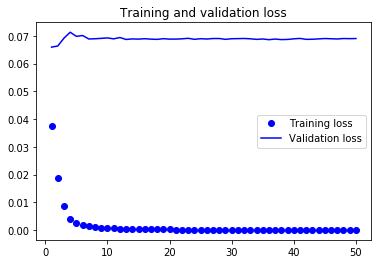

In [38]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=0.28, random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
word_input_tensor = Input(shape=(maxlen,) , name='words')
# model = Sequential()
# model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.MaxPooling1D(2))
# model.add(layers.Flatten())
# model.add(layers.Conv1D(32, 3, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.SimpleRNN(embedding_dim, dropout=0.1, recurrent_dropout=0.5, return_sequences= True))
# model.add(layers.SimpleRNN(embedding_dim))
# model.add(Dense(embedding_dim, activation='relu'))
# model.add(layers.Dense(len(set(train_labels)), activation='softmax'))
x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
x = layers.Conv1D(32, 3, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
y = layers.Conv1D(32, 5, activation='relu')(x)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 3, activation='relu')(y)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 5, activation='relu')(y)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 5, activation='relu')(y)
y = layers.GlobalMaxPooling1D()(y)


added = layers.add([y, x])

answer = layers.Dense(len(set(train_labels)), activation='softmax')(added)

model_f = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='mse',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, 1020)         0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 32)           69503       words[0][0]                      
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 32)           72031       words[0][0]                      
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64)           0           sequential_15[1][0]              
                                                                 sequential_16[1][0]              
__________

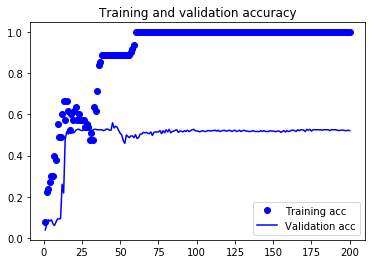

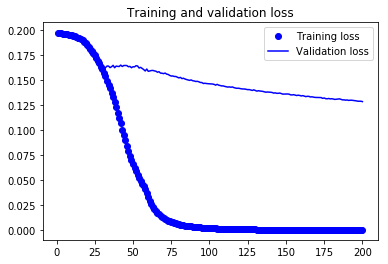

In [18]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=0.28, random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
word_input_tensor = Input(shape=(maxlen,) , name='words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s3_model.add(layers.Dropout(0.1))
conv_1d_s3_model.add(layers.Conv1D(32, 3, activation='relu'))
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

word_output_tensor_0 = conv_1d_s3_model(word_input_tensor)

conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Conv1D(32, 1, activation='relu'))
conv_1d_s1_model.add(layers.MaxPooling1D(1))
conv_1d_s1_model.add(layers.Conv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

word_output_tensor_1 = conv_1d_s1_model(word_input_tensor)

concatenated = layers.concatenate([word_output_tensor_0, word_output_tensor_1], axis=-1)

answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='mae',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
